In [50]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import geometry_mask

# Download data if needed

## Download Sentinel-2 data

In [51]:
!rm download*
!wget https://cloud.irit.fr/s/E22CahuMVTBhsbI/download
!unzip download
!rm download
!mv sentinel2_bands data

rm: cannot remove 'download*': No such file or directory
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
unzip:  cannot find or open download, download.zip or download.ZIP.
rm: cannot remove 'download': No such file or directory
mv: cannot stat 'sentinel2_bands': No such file or directory


## Download elevation data

In [52]:
!rm download*
!wget https://cloud.irit.fr/s/HBeMWkfLvhkysrf/download
!unzip download
!rm download
!mv 'Elevation data' data/elevation_data

rm: cannot remove 'download*': No such file or directory
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
unzip:  cannot find or open download, download.zip or download.ZIP.
rm: cannot remove 'download': No such file or directory
mv: cannot stat 'Elevation data': No such file or directory


## Download geojson dataset

In [53]:
!rm download*
!wget https://cloud.irit.fr/s/3hEr67GQ2C4bWG9/download
!mv download data/dataset.geojson

rm: cannot remove 'download*': No such file or directory
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
mv: cannot stat 'download': No such file or directory


# Define paths

Data tree path should look like this:
```
.  
|__data/  
    |__sentinel2_bands/<year>/<month>/<band>
    |__elevation_data/  
    |__dataset.geojson
```

In [54]:
import os

def get_altitude_data_path() -> str:
    return os.path.abspath("./data/elevation_data/raw_elevation_data_10m.tif")

def get_geojson_path() -> str:
    return os.path.abspath("./data/dataset.geojson")
    
def get_sentinel_data_path() -> dict:
    paths = {}
    years = os.listdir("data/sentinel2_bands")
    for year in years:
        y = int(year)
        paths[y] = {}
        months = os.listdir(f"data/sentinel2_bands/{year}")
        for month in months:
            m = int(month.split("_")[0])
            paths[y][m] = {}
            bands = os.listdir(f"data/sentinel2_bands/{year}/{month}/") 
            for band in bands:
                band_name = band.split("_")[2]
                paths[y][m][band_name] = os.path.abspath(f"./data/sentinel2_bands/{year}/{month}/{band}")
    return paths

sentinel_data_path = get_sentinel_data_path()
altitude_path = get_altitude_data_path()
geojson_path = get_geojson_path()

print(altitude_path)
print(geojson_path)
print(f"Data path for sentinel-2, 2019, february, red band: {sentinel_data_path[2019][2]['B03']}")

c:\Users\leoma\ter\Ter-2024\data\elevation_data\raw_elevation_data_10m.tif
c:\Users\leoma\ter\Ter-2024\data\dataset.geojson
Data path for sentinel-2, 2019, february, red band: c:\Users\leoma\ter\Ter-2024\data\sentinel2_bands\2019\02_february\T31TEJ_20190227T104019_B03_10m.jp2


In [55]:
# Load metadata and band data
band_names = ["Blue", "Green", "Red", "NIR"]
month = 2 #February
bands = [ rasterio.open(sentinel_data_path[2019][month]['B02']).read(1).astype('float32') ,rasterio.open(sentinel_data_path[2019][month]['B03']).read(1).astype('float32'), rasterio.open(sentinel_data_path[2019][month]['B04']).read(1).astype('float32') ,rasterio.open(sentinel_data_path[2019][month]['B08']).read(1).astype('float32')]
meta = rasterio.open(sentinel_data_path[2019][month]['B08']).meta

altitude = rasterio.open(altitude_path).read(1).astype('float32')

altitude = np.where(np.isfinite(altitude), np.where(altitude < -500, 0, altitude), np.nan)
altitude = np.where(np.isnan(altitude), 0, altitude)


In [56]:
# Function to plot bands
def plot(arr, title):
    plt.imshow(arr)
    plt.axis('off')
    plt.colorbar()
    plt.title(title)
    plt.show()

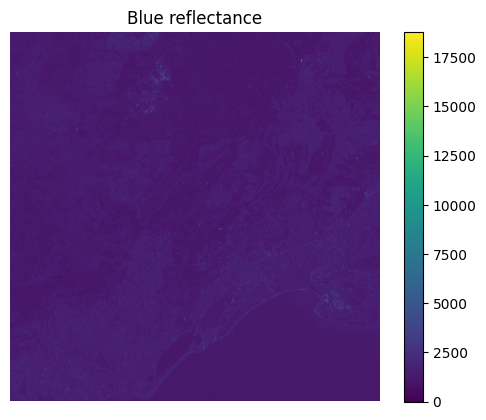

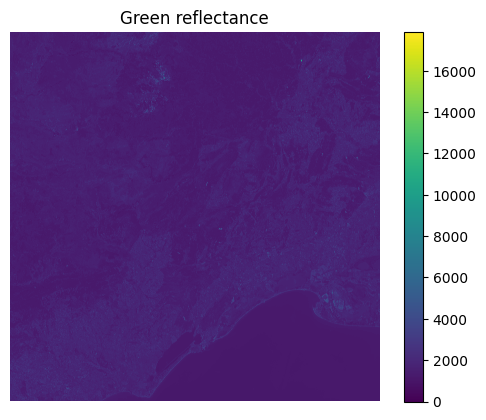

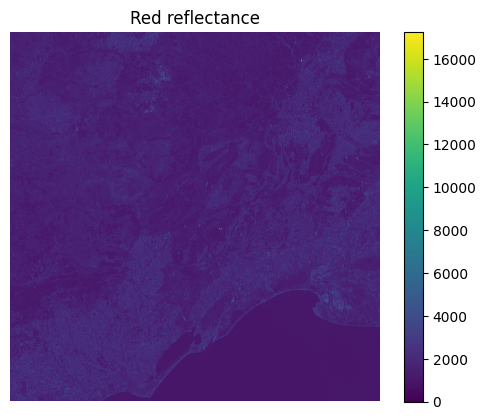

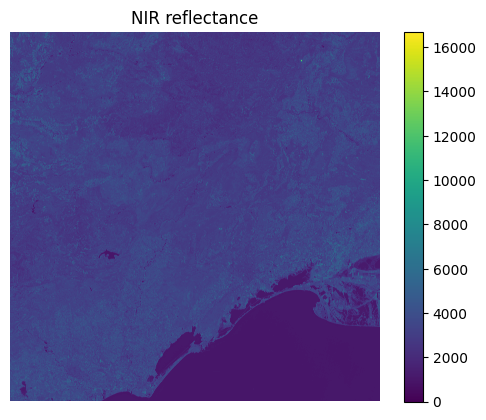

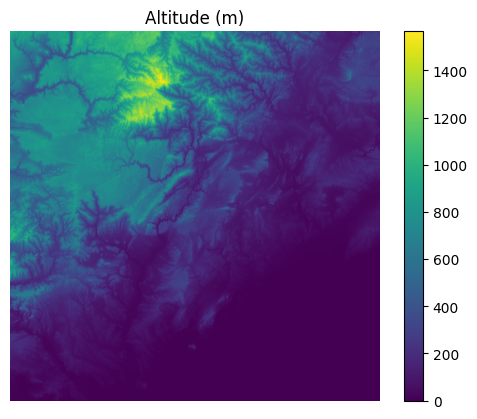

In [57]:
# Plot the bands
plot(bands[0], "Blue reflectance")
plot(bands[1], "Green reflectance")
plot(bands[2], "Red reflectance")
plot(bands[3], "NIR reflectance")
plot(altitude, "Altitude (m)")

In [58]:
transform = meta['transform']
crs = meta['crs']
shape = meta['height'], meta['width']
meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32631),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 4900020.0)}

In [59]:
gdf = gpd.read_file(geojson_path)
gdf = gdf.to_crs(crs)

In [60]:
labels = ["Limite", "Assez_limite", "Moyen", "Assez_fort", "Fort_a_tres_fort"]

# Create the mask
mask = np.zeros(shape, dtype=bool)
for label in labels:
    mask = geometry_mask(gdf[gdf["pot_global"] == label].geometry, 
                         out_shape=shape, 
                         transform=transform, 
                         invert=True)
    mask |= mask

In [61]:
# Resample altitude data to match the other bands
with rasterio.open(altitude_path) as src:
    altitude_meta = src.meta
    transform, width, height = calculate_default_transform(
        src.crs, meta['crs'], meta['width'], meta['height'], *src.bounds)
    altitude_resampled = np.zeros((meta['height'], meta['width']), np.float32)

    reproject(
        source=rasterio.band(src, 1),
        destination=altitude_resampled,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=meta['transform'],
        dst_crs=meta['crs'],
        resampling=Resampling.nearest)

In [62]:
# Create 3D array to hold band values
values = np.zeros((bands[0].shape[0], bands[0].shape[1], 5), dtype='float32')

# Fill values array with band data
for i, (band ,band_name) in enumerate(zip(bands, band_names)):
    values[:, :, i][mask] = band[mask]
    values[:, :, i][~mask] = np.nan
    
altitude_resampled[altitude_resampled <-500] = 0
altitude_resampled[~mask] = np.nan # for illustration only
# elevation_resampled[~mask] = 0 

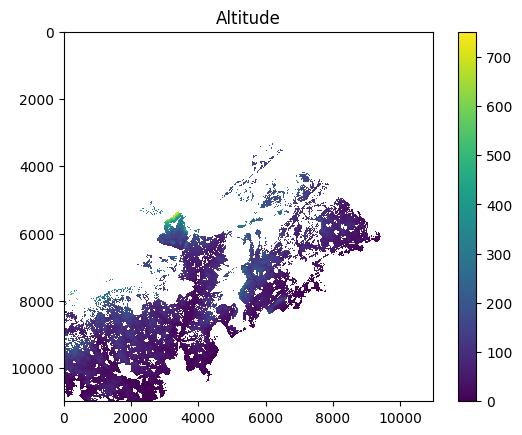

In [63]:
plt.imshow(altitude_resampled, interpolation='nearest')
plt.colorbar()
plt.title("Altitude")
plt.show()

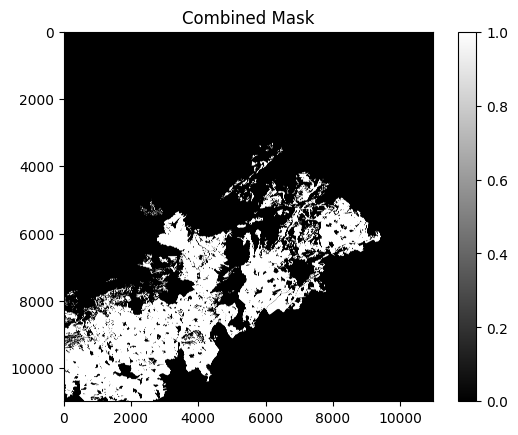

In [64]:
# Display the combined mask
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.colorbar()
plt.show()

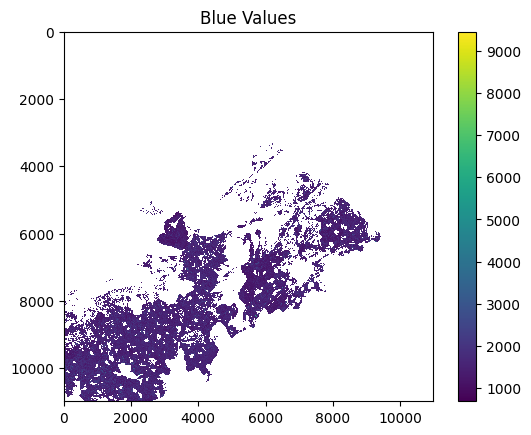

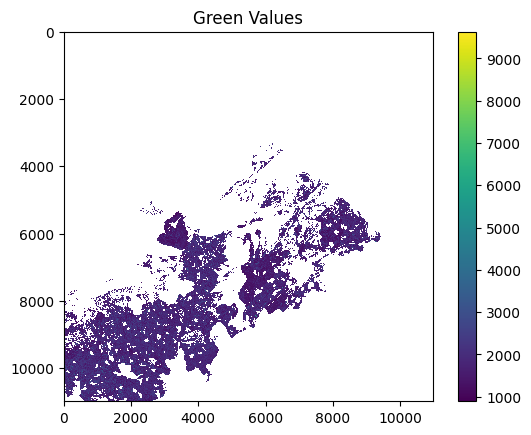

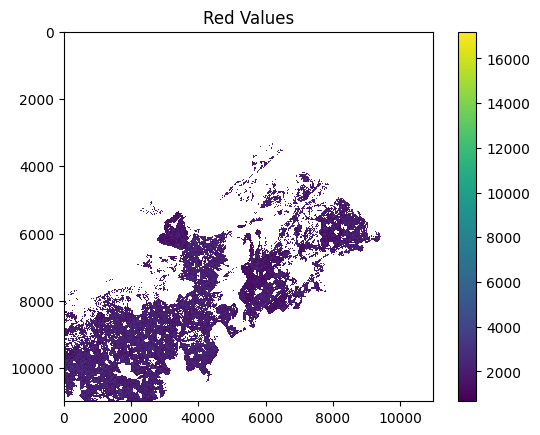

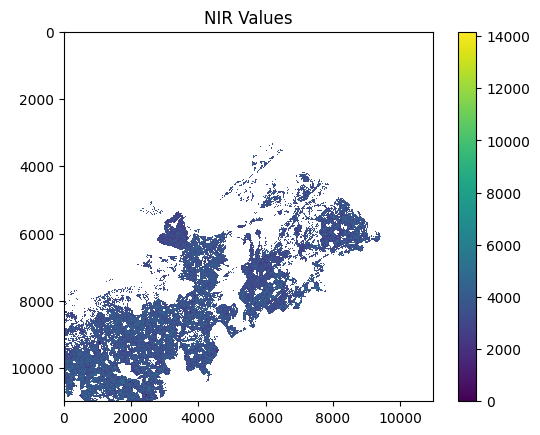

In [67]:
# Display the values for each band
for i, band_name in enumerate(band_names):
    plt.imshow(values[:, :, i], interpolation='nearest')
    plt.title(f"{band_name} Values")
    plt.colorbar()
    plt.show()